In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [92]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))


print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [93]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [94]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [95]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [arch_test[3]] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [96]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [167]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        #theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
        #theta.append(0.01*np.random.standard_normal((dim0, dim1)))
    return theta

In [168]:
def activation(x):
    return 1/(1+np.exp(-x))

In [169]:
def relu_act(x):
    return np.maximum(0.0, x)

In [170]:
def softplus(x):
    return np.log(1+np.exp(x))

In [171]:
def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [172]:
def deriv_relu(x):
    #x[x<=0] = -0.01
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [173]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        if (l != len(theta)-1):
            #print("relu")
            fm.append(relu_act(np.dot(fm[l], theta[l])))
        else:
            fm.append(activation(np.dot(fm[l], theta[l])))
            #print("sigmoid output")
    return fm

In [174]:
theta = theta_init([100, 100, 100])
print(theta[3].shape)
cost_total(X_train, theta, train_class_enc, m)
#fm = forward_prop(X_train, theta)

(100, 26)


3.249991648690502

In [175]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [176]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [188]:
epochs = []
train_accuracy = []
valid_accuracy =[]
test_accuracy = []
train_time = []

In [205]:
arch=[100, 100]
lr=0.1
theta = theta_init(arch)
print(theta[0].shape, theta[1].shape, theta[2].shape)

(785, 100) (100, 100) (100, 26)


In [206]:
costs = []
epoch = 1
start = time.time()
#cost_init = cost_total(X_train, theta, train_class_enc, m) #Validation loss not giving much info
cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0]) #Validation loss not giving much info
costs.append(cost_init)
early_stop= 0
while(True):
    count = 0
    #lr = lr0/(np.power(epoch, 1/3))
    #if(lr < 0.001): lr = 0.001
    print("learning rate = ", lr)

    print("Initial Cost on dataset for this epoch {} = {}".format(epoch, cost_init))

    for b in mini_batch:
        X_b = b[0]
        Y_b = b[1]
        fm = forward_prop(X_b, theta)
        delta = [None]*len(fm)

        if (count % 60 == 0):
            print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
        #Backward Propagation

        for l in range(len(fm)-1, 0, -1):
            if (l == len(fm)-1):
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                #print("delta for last layer=",delta[l])
            else:
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
                #print("delta for hidden layer=",np.mean(delta[l]))

        for t in range(len(theta)):
            theta[t] += lr*np.dot(fm[t].T, delta[t+1])
        
        count+=1
    epoch+=1 #Number of epochs
    #ite+=1

    #cost_final = cost_total(X_train, theta, train_class_enc, m)
    cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
    if(epoch%10==0): costs.append(cost_final)
    print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
    
    if ((cost_final-cost_init) > 0):
        early_stop +=1
    else:
        early_stop=0
    if (early_stop == 30):
        print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
        break

    cost_init = cost_final
    
    
epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer arch= {} are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs = {:2.3f}".format(epochs[-1]))
print("The training time = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

learning rate =  0.1
Initial Cost on dataset for this epoch 1 = 3.2501942833744635
Error on this batch = 3.2501647437457426
Error on this batch = 0.4903101404871288
Cost on val dataset after 2 epochs is = 0.4904962491827453
learning rate =  0.1
Initial Cost on dataset for this epoch 2 = 0.4904962491827453
Error on this batch = 0.4898654351655779
Error on this batch = 0.49084832652871413
Cost on val dataset after 3 epochs is = 0.4897246698929074
learning rate =  0.1
Initial Cost on dataset for this epoch 3 = 0.4897246698929074
Error on this batch = 0.4891033080706278
Error on this batch = 0.4910352164460997
Cost on val dataset after 4 epochs is = 0.4893057323191314
learning rate =  0.1
Initial Cost on dataset for this epoch 4 = 0.4893057323191314
Error on this batch = 0.4886152608396129
Error on this batch = 0.491053676763863
Cost on val dataset after 5 epochs is = 0.4889798295174246
learning rate =  0.1
Initial Cost on dataset for this epoch 5 = 0.4889798295174246
Error on this batch =

Error on this batch = 0.4807131423062389
Cost on val dataset after 38 epochs is = 0.48087115764485816
learning rate =  0.1
Initial Cost on dataset for this epoch 38 = 0.48087115764485816
Error on this batch = 0.48076955842185326
Error on this batch = 0.4807017166197393
Cost on val dataset after 39 epochs is = 0.4808642972075116
learning rate =  0.1
Initial Cost on dataset for this epoch 39 = 0.4808642972075116
Error on this batch = 0.48076214762231695
Error on this batch = 0.48069131214777544
Cost on val dataset after 40 epochs is = 0.4808576294008549
learning rate =  0.1
Initial Cost on dataset for this epoch 40 = 0.4808576294008549
Error on this batch = 0.48075550286305774
Error on this batch = 0.48068173427820854
Cost on val dataset after 41 epochs is = 0.4808510091372489
learning rate =  0.1
Initial Cost on dataset for this epoch 41 = 0.4808510091372489
Error on this batch = 0.48074942892183486
Error on this batch = 0.48067272395704136
Cost on val dataset after 42 epochs is = 0.480

Error on this batch = 0.4801842545978018
Cost on val dataset after 74 epochs is = 0.48034777157399744
learning rate =  0.1
Initial Cost on dataset for this epoch 74 = 0.48034777157399744
Error on this batch = 0.4804471282280059
Error on this batch = 0.4801507418252814
Cost on val dataset after 75 epochs is = 0.4803104696956664
learning rate =  0.1
Initial Cost on dataset for this epoch 75 = 0.4803104696956664
Error on this batch = 0.48042818686936145
Error on this batch = 0.4801151566252274
Cost on val dataset after 76 epochs is = 0.4802708197361791
learning rate =  0.1
Initial Cost on dataset for this epoch 76 = 0.4802708197361791
Error on this batch = 0.4804082516592958
Error on this batch = 0.4800775129474337
Cost on val dataset after 77 epochs is = 0.48022876652870866
learning rate =  0.1
Initial Cost on dataset for this epoch 77 = 0.48022876652870866
Error on this batch = 0.48038712726206984
Error on this batch = 0.48003682309196294
Cost on val dataset after 78 epochs is = 0.48018

Error on this batch = 0.4731268176147729
Cost on val dataset after 110 epochs is = 0.4731426409854353
learning rate =  0.1
Initial Cost on dataset for this epoch 110 = 0.4731426409854353
Error on this batch = 0.4780418264987927
Error on this batch = 0.47233705352768013
Cost on val dataset after 111 epochs is = 0.4723741224053634
learning rate =  0.1
Initial Cost on dataset for this epoch 111 = 0.4723741224053634
Error on this batch = 0.4777406610109991
Error on this batch = 0.47145556195323546
Cost on val dataset after 112 epochs is = 0.471522430472345
learning rate =  0.1
Initial Cost on dataset for this epoch 112 = 0.471522430472345
Error on this batch = 0.4773780898575497
Error on this batch = 0.4704828525749929
Cost on val dataset after 113 epochs is = 0.47058386220639814
learning rate =  0.1
Initial Cost on dataset for this epoch 113 = 0.47058386220639814
Error on this batch = 0.4769477596613041
Error on this batch = 0.4694116819018925
Cost on val dataset after 114 epochs is = 0.4

Error on this batch = 0.4025103032219744
Cost on val dataset after 146 epochs is = 0.4129984389575961
learning rate =  0.1
Initial Cost on dataset for this epoch 146 = 0.4129984389575961
Error on this batch = 0.4353743841397713
Error on this batch = 0.3995979029673724
Cost on val dataset after 147 epochs is = 0.41061022310331147
learning rate =  0.1
Initial Cost on dataset for this epoch 147 = 0.41061022310331147
Error on this batch = 0.4331406638028389
Error on this batch = 0.3967828923103507
Cost on val dataset after 148 epochs is = 0.408280602258144
learning rate =  0.1
Initial Cost on dataset for this epoch 148 = 0.408280602258144
Error on this batch = 0.4309699868656014
Error on this batch = 0.3940985312820536
Cost on val dataset after 149 epochs is = 0.40601951775991824
learning rate =  0.1
Initial Cost on dataset for this epoch 149 = 0.40601951775991824
Error on this batch = 0.4288708240025868
Error on this batch = 0.3915611287183118
Cost on val dataset after 150 epochs is = 0.4

Error on this batch = 0.3425239656819109
Cost on val dataset after 182 epochs is = 0.35530097558013174
learning rate =  0.1
Initial Cost on dataset for this epoch 182 = 0.35530097558013174
Error on this batch = 0.37331902612997203
Error on this batch = 0.34131690524801017
Cost on val dataset after 183 epochs is = 0.35414826263521154
learning rate =  0.1
Initial Cost on dataset for this epoch 183 = 0.35414826263521154
Error on this batch = 0.37172881408530517
Error on this batch = 0.34011572986149935
Cost on val dataset after 184 epochs is = 0.35300769149034145
learning rate =  0.1
Initial Cost on dataset for this epoch 184 = 0.35300769149034145
Error on this batch = 0.37015230583583064
Error on this batch = 0.3389161879952484
Cost on val dataset after 185 epochs is = 0.351890980696997
learning rate =  0.1
Initial Cost on dataset for this epoch 185 = 0.351890980696997
Error on this batch = 0.36859099023734887
Error on this batch = 0.3377216822691453
Cost on val dataset after 186 epochs 

Error on this batch = 0.3034721201973825
Cost on val dataset after 218 epochs is = 0.3211164288964928
learning rate =  0.1
Initial Cost on dataset for this epoch 218 = 0.3211164288964928
Error on this batch = 0.32406479425459156
Error on this batch = 0.3024491785595373
Cost on val dataset after 219 epochs is = 0.3202779717920785
learning rate =  0.1
Initial Cost on dataset for this epoch 219 = 0.3202779717920785
Error on this batch = 0.3228579814855675
Error on this batch = 0.30142929503077937
Cost on val dataset after 220 epochs is = 0.31943511362152927
learning rate =  0.1
Initial Cost on dataset for this epoch 220 = 0.31943511362152927
Error on this batch = 0.3216508564257965
Error on this batch = 0.30042458691219376
Cost on val dataset after 221 epochs is = 0.31859463249922454
learning rate =  0.1
Initial Cost on dataset for this epoch 221 = 0.31859463249922454
Error on this batch = 0.32045324751093757
Error on this batch = 0.29943444919569323
Cost on val dataset after 222 epochs i

Error on this batch = 0.2701473224014512
Cost on val dataset after 254 epochs is = 0.291829577634163
learning rate =  0.1
Initial Cost on dataset for this epoch 254 = 0.291829577634163
Error on this batch = 0.2863905316560982
Error on this batch = 0.2692436223727591
Cost on val dataset after 255 epochs is = 0.29098806769421653
learning rate =  0.1
Initial Cost on dataset for this epoch 255 = 0.29098806769421653
Error on this batch = 0.28539528273488457
Error on this batch = 0.2683551572907554
Cost on val dataset after 256 epochs is = 0.2901428959748846
learning rate =  0.1
Initial Cost on dataset for this epoch 256 = 0.2901428959748846
Error on this batch = 0.28439510644109306
Error on this batch = 0.2674663483649014
Cost on val dataset after 257 epochs is = 0.2892868433666891
learning rate =  0.1
Initial Cost on dataset for this epoch 257 = 0.2892868433666891
Error on this batch = 0.28339915316113323
Error on this batch = 0.2665896234430694
Cost on val dataset after 258 epochs is = 0.

Error on this batch = 0.2380805387442225
Cost on val dataset after 290 epochs is = 0.2615496255086712
learning rate =  0.1
Initial Cost on dataset for this epoch 290 = 0.2615496255086712
Error on this batch = 0.25092973009272873
Error on this batch = 0.23724262381691524
Cost on val dataset after 291 epochs is = 0.2607741109502119
learning rate =  0.1
Initial Cost on dataset for this epoch 291 = 0.2607741109502119
Error on this batch = 0.2500884864612173
Error on this batch = 0.23639588250116694
Cost on val dataset after 292 epochs is = 0.25999602129198757
learning rate =  0.1
Initial Cost on dataset for this epoch 292 = 0.25999602129198757
Error on this batch = 0.24927075248747607
Error on this batch = 0.23553613057442144
Cost on val dataset after 293 epochs is = 0.2592216410707274
learning rate =  0.1
Initial Cost on dataset for this epoch 293 = 0.2592216410707274
Error on this batch = 0.24844370553596778
Error on this batch = 0.23470951480261126
Cost on val dataset after 294 epochs i

Error on this batch = 0.20959052674727738
Cost on val dataset after 326 epochs is = 0.2343400161501431
learning rate =  0.1
Initial Cost on dataset for this epoch 326 = 0.2343400161501431
Error on this batch = 0.2225091194806259
Error on this batch = 0.20882311930018546
Cost on val dataset after 327 epochs is = 0.23364461184156457
learning rate =  0.1
Initial Cost on dataset for this epoch 327 = 0.23364461184156457
Error on this batch = 0.22160010905952462
Error on this batch = 0.20806030927501717
Cost on val dataset after 328 epochs is = 0.23295195336099103
learning rate =  0.1
Initial Cost on dataset for this epoch 328 = 0.23295195336099103
Error on this batch = 0.22069160947962702
Error on this batch = 0.20728797432757184
Cost on val dataset after 329 epochs is = 0.23227468833523468
learning rate =  0.1
Initial Cost on dataset for this epoch 329 = 0.23227468833523468
Error on this batch = 0.21980182871298568
Error on this batch = 0.20649850388633254
Cost on val dataset after 330 epo

Error on this batch = 0.1826454471262071
Cost on val dataset after 362 epochs is = 0.21146670533484274
learning rate =  0.1
Initial Cost on dataset for this epoch 362 = 0.21146670533484274
Error on this batch = 0.19285509378580276
Error on this batch = 0.18190522174868004
Cost on val dataset after 363 epochs is = 0.21085094096804013
learning rate =  0.1
Initial Cost on dataset for this epoch 363 = 0.21085094096804013
Error on this batch = 0.19213947976617288
Error on this batch = 0.18116180717638755
Cost on val dataset after 364 epochs is = 0.21023988807009797
learning rate =  0.1
Initial Cost on dataset for this epoch 364 = 0.21023988807009797
Error on this batch = 0.19142929735740238
Error on this batch = 0.18043597702908049
Cost on val dataset after 365 epochs is = 0.20962167083325886
learning rate =  0.1
Initial Cost on dataset for this epoch 365 = 0.20962167083325886
Error on this batch = 0.19071718038829893
Error on this batch = 0.1797137272698584
Cost on val dataset after 366 ep

Error on this batch = 0.1609145187138526
Cost on val dataset after 398 epochs is = 0.19038887467741633
learning rate =  0.1
Initial Cost on dataset for this epoch 398 = 0.19038887467741633
Error on this batch = 0.1684860437782801
Error on this batch = 0.1603322665753958
Cost on val dataset after 399 epochs is = 0.18990255829090935
learning rate =  0.1
Initial Cost on dataset for this epoch 399 = 0.18990255829090935
Error on this batch = 0.16785934364329427
Error on this batch = 0.15973993852927965
Cost on val dataset after 400 epochs is = 0.1894084896462124
learning rate =  0.1
Initial Cost on dataset for this epoch 400 = 0.1894084896462124
Error on this batch = 0.16723866810778373
Error on this batch = 0.15916222778427722
Cost on val dataset after 401 epochs is = 0.1889233371441716
learning rate =  0.1
Initial Cost on dataset for this epoch 401 = 0.1889233371441716
Error on this batch = 0.1666315138353149
Error on this batch = 0.15854153151618647
Cost on val dataset after 402 epochs i

Error on this batch = 0.1429877864724854
Cost on val dataset after 434 epochs is = 0.17618051025310205
learning rate =  0.1
Initial Cost on dataset for this epoch 434 = 0.17618051025310205
Error on this batch = 0.15172856049048639
Error on this batch = 0.14258599075429104
Cost on val dataset after 435 epochs is = 0.1758956302331279
learning rate =  0.1
Initial Cost on dataset for this epoch 435 = 0.1758956302331279
Error on this batch = 0.15138169628165465
Error on this batch = 0.14220384913071624
Cost on val dataset after 436 epochs is = 0.17560400316279273
learning rate =  0.1
Initial Cost on dataset for this epoch 436 = 0.17560400316279273
Error on this batch = 0.15104472728050802
Error on this batch = 0.14182646927400705
Cost on val dataset after 437 epochs is = 0.1753108649818463
learning rate =  0.1
Initial Cost on dataset for this epoch 437 = 0.1753108649818463
Error on this batch = 0.15070621539762197
Error on this batch = 0.14144219696962615
Cost on val dataset after 438 epoch

Error on this batch = 0.1308772141615699
Cost on val dataset after 470 epochs is = 0.16809072304504974
learning rate =  0.1
Initial Cost on dataset for this epoch 470 = 0.16809072304504974
Error on this batch = 0.142159936269641
Error on this batch = 0.13055737011235785
Cost on val dataset after 471 epochs is = 0.16792038199680173
learning rate =  0.1
Initial Cost on dataset for this epoch 471 = 0.16792038199680173
Error on this batch = 0.1419425117486961
Error on this batch = 0.13026256952650342
Cost on val dataset after 472 epochs is = 0.16776504537400247
learning rate =  0.1
Initial Cost on dataset for this epoch 472 = 0.16776504537400247
Error on this batch = 0.14170562374564147
Error on this batch = 0.1299726169460428
Cost on val dataset after 473 epochs is = 0.16758820377406286
learning rate =  0.1
Initial Cost on dataset for this epoch 473 = 0.16758820377406286
Error on this batch = 0.14148982276079422
Error on this batch = 0.1296729515844374
Cost on val dataset after 474 epochs

Error on this batch = 0.12089755524547226
Cost on val dataset after 506 epochs is = 0.1640563267056638
learning rate =  0.1
Initial Cost on dataset for this epoch 506 = 0.1640563267056638
Error on this batch = 0.13592116204405366
Error on this batch = 0.12062663753334628
Cost on val dataset after 507 epochs is = 0.16398936297691163
learning rate =  0.1
Initial Cost on dataset for this epoch 507 = 0.16398936297691163
Error on this batch = 0.1357756492581884
Error on this batch = 0.12035827018576326
Cost on val dataset after 508 epochs is = 0.16393272129170042
learning rate =  0.1
Initial Cost on dataset for this epoch 508 = 0.16393272129170042
Error on this batch = 0.13563359265654612
Error on this batch = 0.12012366709326515
Cost on val dataset after 509 epochs is = 0.16387935222538205
learning rate =  0.1
Initial Cost on dataset for this epoch 509 = 0.16387935222538205
Error on this batch = 0.1355136717326249
Error on this batch = 0.11989015993679455
Cost on val dataset after 510 epoc

Error on this batch = 0.11428261931980206
Cost on val dataset after 542 epochs is = 0.16255692233458757
learning rate =  0.1
Initial Cost on dataset for this epoch 542 = 0.16255692233458757
Error on this batch = 0.13229851910352788
Error on this batch = 0.11416573218832136
Cost on val dataset after 543 epochs is = 0.162515938790997
learning rate =  0.1
Initial Cost on dataset for this epoch 543 = 0.162515938790997
Error on this batch = 0.13219185391049793
Error on this batch = 0.1140876313889364
Cost on val dataset after 544 epochs is = 0.16251591602713275
learning rate =  0.1
Initial Cost on dataset for this epoch 544 = 0.16251591602713275
Error on this batch = 0.13211811728484854
Error on this batch = 0.11401217062615458
Cost on val dataset after 545 epochs is = 0.16247698492822327
learning rate =  0.1
Initial Cost on dataset for this epoch 545 = 0.16247698492822327
Error on this batch = 0.1320124206434859
Error on this batch = 0.11394541620881216
Cost on val dataset after 546 epochs

Error on this batch = 0.11272341281890036
Cost on val dataset after 578 epochs is = 0.16201140732598704
learning rate =  0.1
Initial Cost on dataset for this epoch 578 = 0.16201140732598704
Error on this batch = 0.12900034172485036
Error on this batch = 0.1126615046382992
Cost on val dataset after 579 epochs is = 0.16199039872868592
learning rate =  0.1
Initial Cost on dataset for this epoch 579 = 0.16199039872868592
Error on this batch = 0.12887511973537089
Error on this batch = 0.11261438969358778
Cost on val dataset after 580 epochs is = 0.16196924462882784
learning rate =  0.1
Initial Cost on dataset for this epoch 580 = 0.16196924462882784
Error on this batch = 0.12876941498658342
Error on this batch = 0.11253857270026521
Cost on val dataset after 581 epochs is = 0.16194503622944262
learning rate =  0.1
Initial Cost on dataset for this epoch 581 = 0.16194503622944262
Error on this batch = 0.12865666125111694
Error on this batch = 0.11244788246664661
Cost on val dataset after 582 e

Error on this batch = 0.10825228866371461
Cost on val dataset after 614 epochs is = 0.16078953057292608
learning rate =  0.1
Initial Cost on dataset for this epoch 614 = 0.16078953057292608
Error on this batch = 0.12583588814432808
Error on this batch = 0.10812526039273496
Cost on val dataset after 615 epochs is = 0.16074725995530575
learning rate =  0.1
Initial Cost on dataset for this epoch 615 = 0.16074725995530575
Error on this batch = 0.12577766081774922
Error on this batch = 0.10801136948349721
Cost on val dataset after 616 epochs is = 0.16069141502642847
learning rate =  0.1
Initial Cost on dataset for this epoch 616 = 0.16069141502642847
Error on this batch = 0.12569542061105715
Error on this batch = 0.10785041450849633
Cost on val dataset after 617 epochs is = 0.1606380131574032
learning rate =  0.1
Initial Cost on dataset for this epoch 617 = 0.1606380131574032
Error on this batch = 0.1255970884902558
Error on this batch = 0.10772284192701845
Cost on val dataset after 618 epo

Error on this batch = 0.10432565658828793
Cost on val dataset after 650 epochs is = 0.1595073603082412
learning rate =  0.1
Initial Cost on dataset for this epoch 650 = 0.1595073603082412
Error on this batch = 0.12442718076719747
Error on this batch = 0.10423537729498705
Cost on val dataset after 651 epochs is = 0.15947055998779883
learning rate =  0.1
Initial Cost on dataset for this epoch 651 = 0.15947055998779883
Error on this batch = 0.12435834930007839
Error on this batch = 0.10414456614645279
Cost on val dataset after 652 epochs is = 0.15946463426035107
learning rate =  0.1
Initial Cost on dataset for this epoch 652 = 0.15946463426035107
Error on this batch = 0.12432369317015418
Error on this batch = 0.10405247507888536
Cost on val dataset after 653 epochs is = 0.15943353336459062
learning rate =  0.1
Initial Cost on dataset for this epoch 653 = 0.15943353336459062
Error on this batch = 0.12425114483439549
Error on this batch = 0.10393819090288245
Cost on val dataset after 654 ep

Error on this batch = 0.10171523379054408
Cost on val dataset after 686 epochs is = 0.15931466197653876
learning rate =  0.1
Initial Cost on dataset for this epoch 686 = 0.15931466197653876
Error on this batch = 0.12352756142473954
Error on this batch = 0.10162922260202757
Cost on val dataset after 687 epochs is = 0.15933583491534817
learning rate =  0.1
Initial Cost on dataset for this epoch 687 = 0.15933583491534817
Error on this batch = 0.12354028087790024
Error on this batch = 0.10152474679017436
Cost on val dataset after 688 epochs is = 0.1593517110688788
learning rate =  0.1
Initial Cost on dataset for this epoch 688 = 0.1593517110688788
Error on this batch = 0.12356459092473268
Error on this batch = 0.10143742367168823
Cost on val dataset after 689 epochs is = 0.1593513879458478
learning rate =  0.1
Initial Cost on dataset for this epoch 689 = 0.1593513879458478
Error on this batch = 0.1235511085490165
Error on this batch = 0.10135306656444903
Cost on val dataset after 690 epoch

In [207]:
cost_total(X_train, theta, train_class_enc, m)

0.12953123909740702

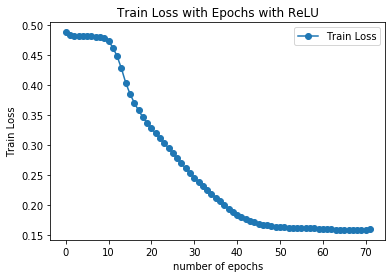

In [208]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Train Loss with Epochs with ReLU")
x = np.arange(0,len(costs[1:300]))
ax.plot(x, costs[1:300], marker='o', label='Train Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("relu_trainloss.png", dpi=1000, bbox_inches='tight')
plt.show()

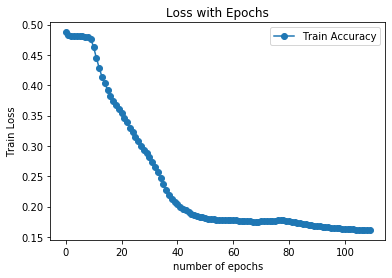

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()